In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sb
import re
%matplotlib inline

I picked a data set from https://www.kaggle.com/aricht1995/european-football-market-values that contains web scrapped (rvest) Market Value information and other related data on Players from the top 9 European leagues including: Premier League, La Liga, Liga NOS, Ligue 1, Bundesliga, Seria A, Premier Liga, Eredivisie and Jupiler Pro League (20+ variables).

I would like analyze which features correlate with the Market Value (Euros). Hence, I'm looking at the average Market Value (Euros) by Position and League. I'm also interested in the mean Height (meters) of players by their position. Additionally I'm using the k-nearest neighbor classifier to predict the League of a player based on it's Position 2, Nationality, and Market Value (Euros) by.

# 1 Data Wrangling

## 1.1 Gather Data

In [2]:
#read in csv file I downloaded from https://www.kaggle.com/aricht1995/european-football-market-values and assign it to a pandas DataFrame
df = pd.read_csv('European_Rosters.csv')

## 1.2 Assess data

In [3]:
#display all columns included in DataFrame
pd.set_option('display.max_columns', None)
df.head()

,FullName,PlayerName,Affiliation,League,Jersey,Birth Date,Age,birthPlace,Height (meters),Citizenship 1,Citizenship 2,Position,Position 2,Foot,Agent,JoinedClub,LastExtension,ContractExpiration,PlayerSponsor,Youth Club 1,Youth Club 2,Youth Club 3,Youth Club 4,Youth Club 5,Youth Club 6,Youth Club 7,nationality,Games Played,Market Value (Euros),Last Updated Date,Accumulated Transfer Sums (Euros),Highest Market Value (Euros),Highest Market Value Date,NationalTeamCaps,MostRecentInjury
0,Anthony Mbu Agogo Modeste,Anthony Modeste,1. FC Koln,Bundesliga,#27,4/14/1988,31,Cannes,1.87,France,Martinique,Forward,Centre-Forward,right,NaN,NaN,NaN,30.06.2023,NaN,ES Fréjus (2001–2003),OGC Nizza (2003–2006),NaN,NaN,NaN,NaN,NaN,France,1,7000000.0,"Last update: Jun 12, 2019",45700000,20000000.0,6/19/2017,16,NaN
1,NaN,Benno Schmitz,1. FC Koln,Bundesliga,#2,11/17/1994,25,München,1.82,Germany,NaN,Defender,Right-Back,right,Kögl & Partner GmbH,NaN,NaN,30.06.2022,NaN,SV Waldperlach (-2001),FC Bayern München (2001-2013),NaN,NaN,NaN,NaN,NaN,Germany,0,1000000.0,"Last update: Jun 12, 2019",1000000,1750000.0,3/22/2017,11,NaN
2,Birger Danny Verstraete,Birger Verstraete,1. FC Koln,Bundesliga,#8,4/16/1994,25,Oostende,1.75,Belgium,NaN,Midfielder,Defensive Midfield,right,SportPlus Football ...,"Jul 1, 2019",NaN,30.06.2023,NaN,KV Oostende (-07/2002),FC BrÃ¼gge,NaN,NaN,NaN,NaN,NaN,Belgium,0,4000000.0,"Last update: Jun 10, 2019",4850000,4000000.0,9/11/2018,1,NaN
3,Brady Canfield Scott,Brady Scott,1. FC Koln,Bundesliga,#31,6/30/1999,20,"Petaluma, California",1.87,United States,NaN,Goalkeeper,Goalkeeper,right,PRO FC,"Jul 1, 2018",NaN,30.06.2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,14,100000.0,"Last update: Jun 12, 2019",0,100000.0,8/3/2018,0,NaN
4,NaN,Christian Clemens,1. FC Koln,Bundesliga,#17,8/4/1991,28,Köln,1.79,Germany,NaN,Midfielder,Right Midfield,right,DC International ...,NaN,NaN,30.06.2021,NaN,SC Weiler-Volkhoven (1997-2001),1.FC Köln (2001-2009),NaN,NaN,NaN,NaN,NaN,Germany,15,1750000.0,"Last update: Jun 12, 2019",7950000,3500000.0,6/29/2013,5,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 35 columns):
FullName                             2052 non-null object
PlayerName                           4308 non-null object
Affiliation                          4308 non-null object
League                               4308 non-null object
Jersey                               4239 non-null object
Birth Date                           4308 non-null object
Age                                  4308 non-null int64
birthPlace                           4150 non-null object
Height (meters)                      4225 non-null float64
Citizenship 1                        4298 non-null object
Citizenship 2                        742 non-null object
Position                             4240 non-null object
Position 2                           4307 non-null object
Foot                                 4098 non-null object
Agent                                3619 non-null object
JoinedClub              

These following columns contain null values:

- FullName
- Jersey
- birthPlace
- Height (meters)
- Citizenship 1
- Citizenship 2
- Position
- Position 2
- Foot
- Agent
- JoinedClub
- LastExtension
- ContractExpiration
- PlayerSponsor
- Youth Club 1
- Youth Club 2
- Youth Club 3
- Youth Club 4
- Youth Club 5
- Youth Club 6
- Youth Club 7
- Market Value (Euros)
- Last Updated Date
- Highest Market Value (Euros)
- Highest Market Value Date
- MostRecentInjury

In [5]:
df.describe()

,Age,Height (meters),Games Played,Market Value (Euros),Accumulated Transfer Sums (Euros),Highest Market Value (Euros),NationalTeamCaps
count,4308.000000,4225.000000,4308.000000,4.289000e+03,4.308000e+03,4.091000e+03,4308.000000
mean,25.451718,1.825931,2.518802,7.714625e+06,7.812063e+06,9.992899e+06,11.292943
std,4.429018,0.066534,10.159712,1.474037e+07,1.741673e+07,1.656523e+07,20.133501
min,16.000000,1.590000,0.000000,2.500000e+04,0.000000e+00,2.500000e+04,0.000000
25%,22.000000,1.780000,0.000000,7.000000e+05,0.000000e+00,1.200000e+06,0.000000
50%,25.000000,1.830000,0.000000,2.500000e+06,1.000000e+06,4.000000e+06,3.000000
75%,29.000000,1.870000,2.000000,8.000000e+06,7.957500e+06,1.200000e+07,12.000000
max,42.000000,2.040000,255.000000,2.000000e+08,3.102000e+08,2.000000e+08,176.000000


In [6]:
#Only 10 out of 16 teams are included in the data set
df[df['League']=='Jupiler Pro League']['Affiliation'].value_counts()

RSC Anderlecht    37
Sint-Truiden      34
Cercle Brugge     34
Standard Liege    33
Royal Antwerp     32
KAA Gent          32
Club Brugge       27
RSC Charleroi     27
KRC Genk          27
Zulte Waregem     27
Name: Affiliation, dtype: int64

1) Drop following columns:

- FullName
- Citizenship 1
- Citizenship 2
- Youth Club 1
- Youth Club 2
- Youth Club 3
- Youth Club 4
- Youth Club 5
- Youth Club 6
- Youth Club 7
- PlayerSponsor
- LastExtension
- Agent
- MostRecentInjury
- Jersey
- birthPlace
- JoinedClub
- ContractExpiration'

2) Drop rows where 

- Market Value (Euros) is NaN (19 rows)

3) Replace NaN/NaT values:

- If Highest Market Value (Euros) is NaN Then replace it by Market Value (Euros)
- If Highest Market Value Date is NaT Then replace it by Last Updated Date


## 1.3 Clean Data

In [7]:
#creating a copy of the DataFrame to don't make changes to the original DataFrame
df_clean = df.copy()

In [8]:
#dropping not needed columns
df_clean.drop(['FullName', 'Citizenship 1', 'Citizenship 2', 'Youth Club 1', 'Youth Club 2', 'Youth Club 3', 'Youth Club 4', 'Youth Club 5', 'Youth Club 6', 'Youth Club 7', 'PlayerSponsor','LastExtension', 'Agent', 'MostRecentInjury','Jersey', 'birthPlace', 'JoinedClub', 'ContractExpiration'], axis=1, inplace=True)

In [9]:
#drop rows where 'Market Value (Euros)', 'Last Updated Date','Position' is NULL
df_clean.dropna(subset = ['Market Value (Euros)', 'Last Updated Date','Position'], inplace=True)

In [10]:
#rename column to have a consitent naming convention
df_clean = df_clean.rename(columns={'nationality': 'Nationality'})

In [11]:
#get value_counts of column 'Last Updated Date'
df_clean['Last Updated Date'].value_counts()

Last update: Jun 5, 2019     400
Last update: Jun 3, 2019     347
Last update: Jun 14, 2019    345
Last update: Jun 11, 2019    344
Last update: Jun 6, 2019     332
Last update: Jun 13, 2019    318
Last update: Jun 12, 2019    281
Last update: Jun 7, 2019     234
Last update: Jun 10, 2019    171
Last update: Jun 29, 2019    152
Last update: Oct 11, 2019    137
Last update: Sep 19, 2019    132
Last update: Sep 12, 2019    129
Last update: Sep 27, 2019    115
Last update: Oct 2, 2019      94
Last update: Sep 10, 2019     94
Last update: Oct 8, 2019      85
Last update: Sep 13, 2019     82
Last update: Jun 28, 2019     75
Last update: Jun 27, 2019     50
Last update: Jul 3, 2019      41
Last update: Jun 4, 2019      34
Last update: Jul 28, 2019     18
Last update: Jul 25, 2019     16
Last update: Aug 1, 2019      15
Last update: Jul 24, 2019     15
Last update: May 21, 2019     11
Last update: Jun 25, 2019     11
Last update: Jun 17, 2019     10
Last update: Jun 20, 2019      9
          

In [12]:
#remove string 'Last update: ' to isolate the date
df_clean['Last Updated Date'] = df_clean['Last Updated Date'].str.replace('Last update: ', '')

In [13]:
#convert applicable columns to datetime64[ns]
df_clean['Birth Date'] = pd.to_datetime(df['Birth Date'])
df_clean['Highest Market Value Date'] = pd.to_datetime(df_clean['Highest Market Value Date'])
df_clean['Last Updated Date'] = pd.to_datetime(df_clean['Last Updated Date'])

In [14]:
#check if the datetime64[ns] transformation worked
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 0 to 4307
Data columns (total 17 columns):
PlayerName                           4230 non-null object
Affiliation                          4230 non-null object
League                               4230 non-null object
Birth Date                           4230 non-null datetime64[ns]
Age                                  4230 non-null int64
Height (meters)                      4215 non-null float64
Position                             4230 non-null object
Position 2                           4229 non-null object
Foot                                 4071 non-null object
Nationality                          4230 non-null object
Games Played                         4230 non-null int64
Market Value (Euros)                 4230 non-null float64
Last Updated Date                    4230 non-null datetime64[ns]
Accumulated Transfer Sums (Euros)    4230 non-null int64
Highest Market Value (Euros)         4063 non-null float64
Highest

In [15]:
# If the value of column 'Highest Market Value (Euros)' is NULL, replace it by 'Market Value (Euros)' value
df_clean['Highest Market Value (Euros)'] = df_clean.apply(
    lambda i: i['Market Value (Euros)'] if np.isnan(i['Highest Market Value (Euros)']) else i['Highest Market Value (Euros)'],
    axis=1
)

In [16]:
#test if the function worked. Player 'Darko Churlinov' (5) has now a Highest Market Value (Euros) of 400000.0 Euros
df_clean.head(10)

,PlayerName,Affiliation,League,Birth Date,Age,Height (meters),Position,Position 2,Foot,Nationality,Games Played,Market Value (Euros),Last Updated Date,Accumulated Transfer Sums (Euros),Highest Market Value (Euros),Highest Market Value Date,NationalTeamCaps
0,Anthony Modeste,1. FC Koln,Bundesliga,1988-04-14,31,1.87,Forward,Centre-Forward,right,France,1,7000000.0,2019-06-12,45700000,20000000.0,2017-06-19,16
1,Benno Schmitz,1. FC Koln,Bundesliga,1994-11-17,25,1.82,Defender,Right-Back,right,Germany,0,1000000.0,2019-06-12,1000000,1750000.0,2017-03-22,11
2,Birger Verstraete,1. FC Koln,Bundesliga,1994-04-16,25,1.75,Midfielder,Defensive Midfield,right,Belgium,0,4000000.0,2019-06-10,4850000,4000000.0,2018-09-11,1
3,Brady Scott,1. FC Koln,Bundesliga,1999-06-30,20,1.87,Goalkeeper,Goalkeeper,right,United States,14,100000.0,2019-06-12,0,100000.0,2018-08-03,0
4,Christian Clemens,1. FC Koln,Bundesliga,1991-08-04,28,1.79,Midfielder,Right Midfield,right,Germany,15,1750000.0,2019-06-12,7950000,3500000.0,2013-06-29,5
5,Darko Churlinov,1. FC Koln,Bundesliga,2000-07-11,19,1.80,Forward,Left Winger,right,North Macedonia,6,400000.0,2019-07-28,0,400000.0,NaT,1
6,Dominick Drexler,1. FC Koln,Bundesliga,1990-05-26,29,1.82,Midfielder,Attacking Midfield,right,Germany,1,4000000.0,2019-06-12,7050000,4000000.0,2018-08-21,0
7,Ellyes Skhiri,1. FC Koln,Bundesliga,1995-05-10,24,1.85,Midfielder,Defensive Midfield,right,Tunisia,1,12000000.0,2019-06-03,6000000,12000000.0,2019-06-03,28
8,Florian Kainz,1. FC Koln,Bundesliga,1992-10-24,27,1.75,Forward,Left Winger,right,Austria,0,3000000.0,2019-06-12,6850000,4500000.0,2016-06-01,16
9,Ismail Jakobs,1. FC Koln,Bundesliga,1999-08-17,20,1.84,Defender,Left-Back,both,Germany,0,100000.0,2019-07-15,0,100000.0,2019-07-15,0


In [17]:
# If the value of column 'Highest Market Value Date' is NULL, replace it by 'Last Updated Date' value

df_clean['Highest Market Value Date'] = df_clean.apply(
    lambda j: j['Last Updated Date'] if pd.isnull(j['Highest Market Value Date']) else j['Highest Market Value Date'],
    axis=1
)

In [18]:
#test if the function worked. Player 'Darko Churlinov' (5) has now a Highest Market Value Date of 2019-07-28
df_clean.head(10)

,PlayerName,Affiliation,League,Birth Date,Age,Height (meters),Position,Position 2,Foot,Nationality,Games Played,Market Value (Euros),Last Updated Date,Accumulated Transfer Sums (Euros),Highest Market Value (Euros),Highest Market Value Date,NationalTeamCaps
0,Anthony Modeste,1. FC Koln,Bundesliga,1988-04-14,31,1.87,Forward,Centre-Forward,right,France,1,7000000.0,2019-06-12,45700000,20000000.0,2017-06-19,16
1,Benno Schmitz,1. FC Koln,Bundesliga,1994-11-17,25,1.82,Defender,Right-Back,right,Germany,0,1000000.0,2019-06-12,1000000,1750000.0,2017-03-22,11
2,Birger Verstraete,1. FC Koln,Bundesliga,1994-04-16,25,1.75,Midfielder,Defensive Midfield,right,Belgium,0,4000000.0,2019-06-10,4850000,4000000.0,2018-09-11,1
3,Brady Scott,1. FC Koln,Bundesliga,1999-06-30,20,1.87,Goalkeeper,Goalkeeper,right,United States,14,100000.0,2019-06-12,0,100000.0,2018-08-03,0
4,Christian Clemens,1. FC Koln,Bundesliga,1991-08-04,28,1.79,Midfielder,Right Midfield,right,Germany,15,1750000.0,2019-06-12,7950000,3500000.0,2013-06-29,5
5,Darko Churlinov,1. FC Koln,Bundesliga,2000-07-11,19,1.80,Forward,Left Winger,right,North Macedonia,6,400000.0,2019-07-28,0,400000.0,2019-07-28,1
6,Dominick Drexler,1. FC Koln,Bundesliga,1990-05-26,29,1.82,Midfielder,Attacking Midfield,right,Germany,1,4000000.0,2019-06-12,7050000,4000000.0,2018-08-21,0
7,Ellyes Skhiri,1. FC Koln,Bundesliga,1995-05-10,24,1.85,Midfielder,Defensive Midfield,right,Tunisia,1,12000000.0,2019-06-03,6000000,12000000.0,2019-06-03,28
8,Florian Kainz,1. FC Koln,Bundesliga,1992-10-24,27,1.75,Forward,Left Winger,right,Austria,0,3000000.0,2019-06-12,6850000,4500000.0,2016-06-01,16
9,Ismail Jakobs,1. FC Koln,Bundesliga,1999-08-17,20,1.84,Defender,Left-Back,both,Germany,0,100000.0,2019-07-15,0,100000.0,2019-07-15,0


In [19]:
#impute mean for quantitative values
df_clean['Height (meters)'].fillna((df['Height (meters)'].mean()),inplace=True)

In [20]:
#check if imputing the mean worked -> There aren't any NULL values in column 'Height (meters)' anymore
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 0 to 4307
Data columns (total 17 columns):
PlayerName                           4230 non-null object
Affiliation                          4230 non-null object
League                               4230 non-null object
Birth Date                           4230 non-null datetime64[ns]
Age                                  4230 non-null int64
Height (meters)                      4230 non-null float64
Position                             4230 non-null object
Position 2                           4229 non-null object
Foot                                 4071 non-null object
Nationality                          4230 non-null object
Games Played                         4230 non-null int64
Market Value (Euros)                 4230 non-null float64
Last Updated Date                    4230 non-null datetime64[ns]
Accumulated Transfer Sums (Euros)    4230 non-null int64
Highest Market Value (Euros)         4230 non-null float64
Highest

In [21]:
#get value_counts of column 'Foot'
df_clean['Foot'].value_counts()

right    2872
left      998
both      198
-           3
Name: Foot, dtype: int64

In [22]:
#replace '-' by NaN
df_clean['Foot'] = df_clean['Foot'].replace('-',np.NaN)

In [23]:
# '-' was replaced by NaN
df_clean['Foot'].value_counts()

right    2872
left      998
both      198
Name: Foot, dtype: int64

In [24]:
#impute mode for categorical values
df_clean['Foot'].fillna(df_clean['Foot'].mode()[0], inplace=True)

In [25]:
#check if imputing the mode worked -> There aren't any NULL values in column 'Foot' anymore
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 0 to 4307
Data columns (total 17 columns):
PlayerName                           4230 non-null object
Affiliation                          4230 non-null object
League                               4230 non-null object
Birth Date                           4230 non-null datetime64[ns]
Age                                  4230 non-null int64
Height (meters)                      4230 non-null float64
Position                             4230 non-null object
Position 2                           4229 non-null object
Foot                                 4230 non-null object
Nationality                          4230 non-null object
Games Played                         4230 non-null int64
Market Value (Euros)                 4230 non-null float64
Last Updated Date                    4230 non-null datetime64[ns]
Accumulated Transfer Sums (Euros)    4230 non-null int64
Highest Market Value (Euros)         4230 non-null float64
Highest

In [26]:
#get value_counts of column 'Position'
df_clean['Position'].value_counts()

Defender                                                   1394
Midfielder                                                 1177
Forward                                                    1111
Goalkeeper                                                  473
Position:                            Centre                  19
Position:                            Goalkeeper              12
Position:                            Central Midfield         9
Position:                            Right                    8
Position:                            Attacking Midfield       6
Contract expires:                                             6
Position:                            Left                     5
Position:                            Left Winger              4
Position:                            Right Winger             2
Position:                            Defensive Midfield       2
Midfielder                                                    1
Position:                            Sec

In [27]:
#remove not needed strings in column 'Position'
df_clean['Position'].replace(r'(^Position:|Contract expires:)\s*','',regex=True,inplace=True)

In [28]:
#remove not needed strings in column 'Position'
df_clean['Position'].replace(r'(Central Midfield|Attacking Midfield|Defensive Midfield|Midfielder\s*)','Midfielder',regex=True,inplace=True)

In [29]:
#remove not needed strings in column 'Position'
df_clean['Position'].replace(r'(Left Winger|Right Winger|Second Striker|Forward\s*)','Forward',regex=True,inplace=True)

In [30]:
#delete white space
df_clean['Position'] = df_clean['Position'].str.replace('Defender ', 'Defender')

In [31]:
#replace not needed values by NaN
df_clean['Position'].replace(r'(Centre\s*|Right\s*|Left\s*)',np.NaN,regex=True,inplace=True)

In [32]:
#replace not white space values by NaN
df_clean['Position'] = df_clean['Position'].replace('',np.NaN)

In [33]:
#test if the transformation worked
df_clean['Position'].value_counts()

Defender      1394
Midfielder    1195
Forward       1118
Goalkeeper     485
Name: Position, dtype: int64

In [34]:
#impute mode for categorical values
df_clean['Position'].fillna(df_clean['Position'].mode()[0], inplace=True)

In [35]:
#check if imputing the mode worked -> There aren't any NULL values in column 'Position' anymore
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 0 to 4307
Data columns (total 17 columns):
PlayerName                           4230 non-null object
Affiliation                          4230 non-null object
League                               4230 non-null object
Birth Date                           4230 non-null datetime64[ns]
Age                                  4230 non-null int64
Height (meters)                      4230 non-null float64
Position                             4230 non-null object
Position 2                           4229 non-null object
Foot                                 4230 non-null object
Nationality                          4230 non-null object
Games Played                         4230 non-null int64
Market Value (Euros)                 4230 non-null float64
Last Updated Date                    4230 non-null datetime64[ns]
Accumulated Transfer Sums (Euros)    4230 non-null int64
Highest Market Value (Euros)         4230 non-null float64
Highest

In [36]:
#get value_counts of column 'Position 2'
df_clean['Position 2'].value_counts()

Centre-Back                    745
Centre-Forward                 528
Central Midfield               522
Goalkeeper                     487
Right-Back                     351
Left-Back                      324
Defensive Midfield             322
Right Winger                   276
Left Winger                    276
Attacking Midfield             245
Second Striker                  50
Left Midfield                   48
Right Midfield                  39
Contract expires:-               7
Contract expires:30.06.2022      3
Contract expires:30.06.2020      2
Midfielder                       1
Contract expires:30.06.2024      1
Contract expires:30.06.2025      1
Contract expires:30.06.2021      1
Name: Position 2, dtype: int64

In [37]:
#replace values that don't describe a Position by NaN
df_clean['Position 2'].replace(r'^Contract*\s[a-z]*:(-|[0-9]*.[0-9]*.[0-9]*.)',np.NaN,regex=True,inplace=True)

In [38]:
#Use mode of ['Position 2'] WHERE ['Position'] == 'Midfielder'
df_clean['Position 2'] = df_clean['Position 2'].str.replace('Midfielder', 'Central Midfield')

In [39]:
#Transformation worked -> no non-position values anymore
df_clean['Position 2'].value_counts()

Centre-Back           745
Centre-Forward        528
Central Midfield      523
Goalkeeper            487
Right-Back            351
Left-Back             324
Defensive Midfield    322
Left Winger           276
Right Winger          276
Attacking Midfield    245
Second Striker         50
Left Midfield          48
Right Midfield         39
Name: Position 2, dtype: int64

In [40]:
#reset index for DateFrame df_clean
df_clean = df_clean.reset_index()

In [41]:
#Player Lorenzo van Kleef (#96) NaN for 'Position 2'
df_clean.loc[94:100,:]

,index,PlayerName,Affiliation,League,Birth Date,Age,Height (meters),Position,Position 2,Foot,Nationality,Games Played,Market Value (Euros),Last Updated Date,Accumulated Transfer Sums (Euros),Highest Market Value (Euros),Highest Market Value Date,NationalTeamCaps
94,97,John Goossens,ADO Den Haag,Eredivisie,1988-07-25,31,1.740000,Midfielder,Attacking Midfield,left,Netherlands,0,300000.0,2019-06-12,0,1250000.0,2012-07-13,3
95,98,Lex Immers,ADO Den Haag,Eredivisie,1986-06-08,33,1.870000,Midfielder,Attacking Midfield,right,Netherlands,2,850000.0,2019-06-12,3100000,3000000.0,2014-08-11,0
96,99,Lorenzo van Kleef,ADO Den Haag,Eredivisie,2001-01-26,18,1.825931,Defender,NaN,right,Netherlands,0,75000.0,2019-09-19,0,75000.0,2019-09-19,8
97,100,Luuk Koopmans,ADO Den Haag,Eredivisie,1993-11-18,26,1.900000,Goalkeeper,Goalkeeper,right,Netherlands,11,350000.0,2019-06-27,100000,350000.0,2019-03-23,0
98,101,Maarten Rieder,ADO Den Haag,Eredivisie,1999-09-29,20,1.720000,Midfielder,Central Midfield,right,Germany,0,75000.0,2019-08-01,0,75000.0,2019-08-01,0
99,102,Mats van Kins,ADO Den Haag,Eredivisie,1998-12-17,20,1.820000,Midfielder,Left Midfield,left,Netherlands,0,100000.0,2019-06-12,0,100000.0,2018-01-17,0
100,103,Michiel Kramer,ADO Den Haag,Eredivisie,1988-12-03,30,1.960000,Forward,Centre-Forward,right,Netherlands,2,650000.0,2019-09-19,1500000,3000000.0,2016-02-05,0


In [42]:
#impute mode for categorical values based on column 'Position'
for h in range(len(df_clean)):
    if pd.isnull(df_clean['Position 2'][h]):
        df_clean['Position 2'][h] = df_clean[df_clean['Position'] == df_clean['Position'][h]]['Position 2'].mode()[0]
    else: df_clean['Position 2'][h]

/Users/antoniobauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [43]:
#impute mode for categorical values based on column 'Position' worked
df_clean.loc[94:100,:]

,index,PlayerName,Affiliation,League,Birth Date,Age,Height (meters),Position,Position 2,Foot,Nationality,Games Played,Market Value (Euros),Last Updated Date,Accumulated Transfer Sums (Euros),Highest Market Value (Euros),Highest Market Value Date,NationalTeamCaps
94,97,John Goossens,ADO Den Haag,Eredivisie,1988-07-25,31,1.740000,Midfielder,Attacking Midfield,left,Netherlands,0,300000.0,2019-06-12,0,1250000.0,2012-07-13,3
95,98,Lex Immers,ADO Den Haag,Eredivisie,1986-06-08,33,1.870000,Midfielder,Attacking Midfield,right,Netherlands,2,850000.0,2019-06-12,3100000,3000000.0,2014-08-11,0
96,99,Lorenzo van Kleef,ADO Den Haag,Eredivisie,2001-01-26,18,1.825931,Defender,Centre-Back,right,Netherlands,0,75000.0,2019-09-19,0,75000.0,2019-09-19,8
97,100,Luuk Koopmans,ADO Den Haag,Eredivisie,1993-11-18,26,1.900000,Goalkeeper,Goalkeeper,right,Netherlands,11,350000.0,2019-06-27,100000,350000.0,2019-03-23,0
98,101,Maarten Rieder,ADO Den Haag,Eredivisie,1999-09-29,20,1.720000,Midfielder,Central Midfield,right,Germany,0,75000.0,2019-08-01,0,75000.0,2019-08-01,0
99,102,Mats van Kins,ADO Den Haag,Eredivisie,1998-12-17,20,1.820000,Midfielder,Left Midfield,left,Netherlands,0,100000.0,2019-06-12,0,100000.0,2018-01-17,0
100,103,Michiel Kramer,ADO Den Haag,Eredivisie,1988-12-03,30,1.960000,Forward,Centre-Forward,right,Netherlands,2,650000.0,2019-09-19,1500000,3000000.0,2016-02-05,0


# 2 Exploratory Data Analysis

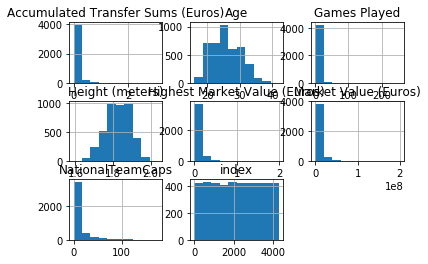

In [44]:
df_clean.hist();

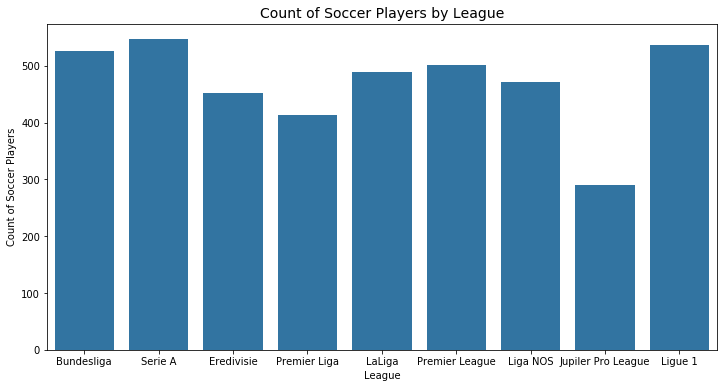

In [45]:
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.countplot(data=df_clean, x='League', color=base_color) 
g.set(xlabel='League', ylabel='Count of Soccer Players')
g.set_title('Count of Soccer Players by League', fontsize=14);

#Serie A, Ligue 1 and Bundesliga have to highest count of players.
#It's surprising to see the Bundesliga in the top 3, as the Bundesliga contains of only 18 teams compared to the Ligue 1, Serie A LaLiga and the Premier League.
#What doesn't surprise me is that the Jupiler Pro League (Belgian First Division A) has the least amount of players, as only 10 of 16 teams are inlcuded in this data set.

In [46]:
player_per_team = df_clean.groupby(['League'])['Affiliation'].count()/df_clean.groupby(['League'])['Affiliation'].nunique()

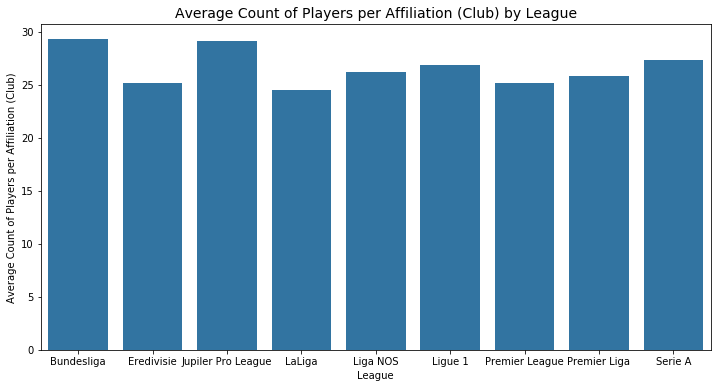

In [47]:
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.barplot(x=player_per_team.index, y=player_per_team, data=df_clean, color=base_color) 
g.set(xlabel='League', ylabel='Average Count of Players per Affiliation (Club)')
g.set_title('Average Count of Players per Affiliation (Club) by League', fontsize=14);

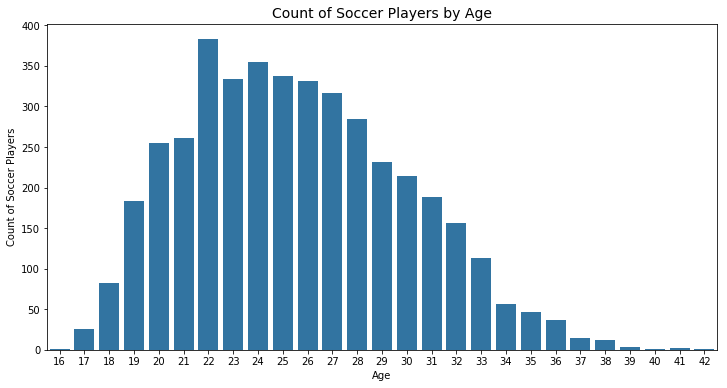

In [48]:
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.countplot(data=df_clean, x='Age', color=base_color) 
g.set(xlabel='Age', ylabel='Count of Soccer Players')
g.set_title('Count of Soccer Players by Age', fontsize=14);

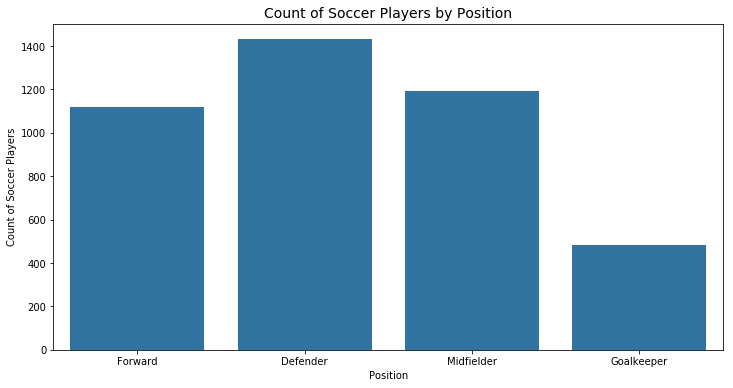

In [49]:
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.countplot(data=df_clean, x='Position', color=base_color) 
g.set(xlabel='Position', ylabel='Count of Soccer Players')
g.set_title('Count of Soccer Players by Position', fontsize=14);

In [50]:
#print(df_clean[df_clean['Height (meters)'].mean()].groupby())
mean_height_by_position = df_clean.groupby(['Position'])['Height (meters)'].mean()
mean_height_by_position

Position
Defender      1.836505
Forward       1.806166
Goalkeeper    1.899526
Midfielder    1.801799
Name: Height (meters), dtype: float64

In [51]:
level_order = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = level_order)
df_clean['Position'] = df_clean['Position'].astype(ordered_cat)

/Users/antoniobauer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


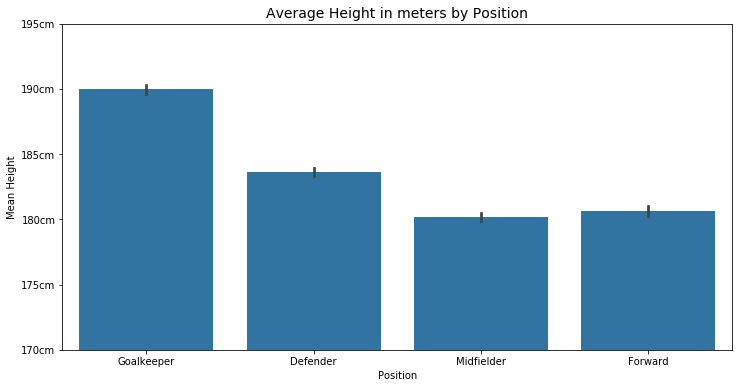

In [52]:
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.barplot(x="Position", y="Height (meters)", data=df_clean, color=base_color) 
g.set(xlabel='Position', ylabel='Mean Height')
g.set_title('Average Height in meters by Position', fontsize=14)
plt.yticks([1.70, 1.75, 1.80, 1.85, 1.90, 1.95, 2.00],['170cm', '175cm', '180cm','185cm', '190cm', '195cm', '200cm']),
g.set(ylim=(1.70, 1.95));

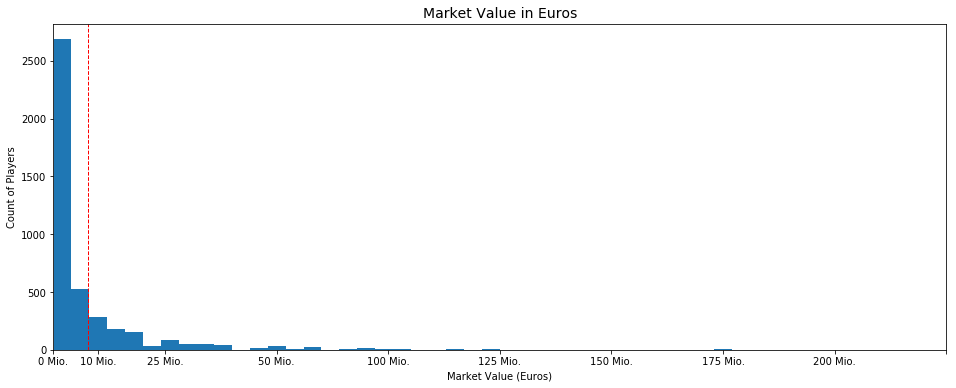

In [53]:
plt.figure(figsize=[16,6])
plt.hist(df_clean['Market Value (Euros)']/1000000, bins=50)
plt.title('Market Value in Euros', fontsize=14)
plt.axvline(df_clean['Market Value (Euros)'].mean()/1000000, color='r', linestyle='dashed', linewidth=1)
plt.ylabel('Count of Players')
plt.xlabel('Market Value (Euros)')
plt.xlim(0, 200)
plt.xticks([0, 10, 25, 50, 75, 100, 125, 150, 175, 200], ['0 Mio.', '10 Mio.', '25 Mio.', '50 Mio.', '100 Mio.', '125 Mio.', '150 Mio.','175 Mio.','200 Mio.']);

In [54]:
market_value_low = df_clean[df_clean['Market Value (Euros)']<=10000000]['Market Value (Euros)']
market_value_high = df_clean[df_clean['Market Value (Euros)']>10000000]['Market Value (Euros)']

In [55]:
df_clean['Market Value (Euros)'].mean()/1000000

7.817222222222222

In [56]:
#df_clean['PlayerName'].max(df_clean['Market Value (Euros)'])
df_clean[df_clean['Market Value (Euros)']>=150000000]

,index,PlayerName,Affiliation,League,Birth Date,Age,Height (meters),Position,Position 2,Foot,Nationality,Games Played,Market Value (Euros),Last Updated Date,Accumulated Transfer Sums (Euros),Highest Market Value (Euros),Highest Market Value Date,NationalTeamCaps
1230,1244,Lionel Messi,FC Barcelona,LaLiga,1987-06-24,32,1.70,Forward,Right Winger,left,Argentina,8,150000000.0,2019-06-11,0,180000000.0,2018-01-01,138
2062,2102,Mohamed Salah,Liverpool,Premier League,1992-06-15,27,1.75,Forward,Right Winger,left,Egypt,6,150000000.0,2019-06-13,81000000,150000000.0,2018-05-28,67
2488,2532,Kylian Mbappe,Paris SG,Ligue 1,1998-12-20,20,1.78,Forward,Centre-Forward,right,France,5,200000000.0,2019-06-03,145000000,200000000.0,2018-12-17,33
2497,2541,Neymar,Paris SG,Ligue 1,1992-02-05,27,1.75,Forward,Left Winger,right,Brazil,4,180000000.0,2019-06-03,310200000,180000000.0,2018-01-24,102
2715,2762,Eden Hazard,Real Madrid,LaLiga,1991-01-07,28,1.75,Forward,Left Winger,both,Belgium,1,150000000.0,2019-06-13,135000000,150000000.0,2018-10-17,106
3488,3550,Harry Kane,Spurs,Premier League,1993-07-28,26,1.88,Forward,Centre-Forward,right,England,6,150000000.0,2019-06-13,0,150000000.0,2018-05-28,43


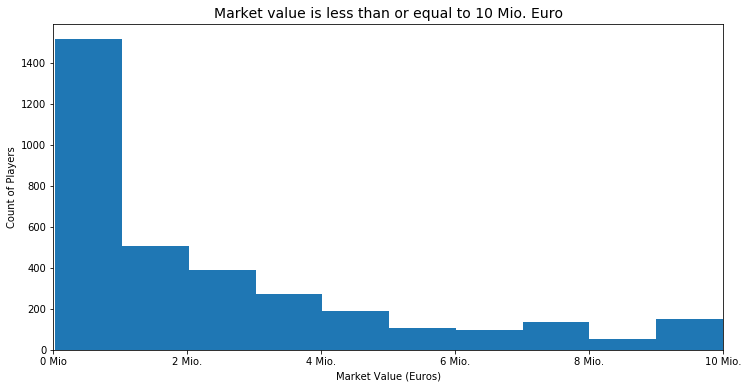

In [57]:
plt.figure(figsize=[12,6])
plt.hist(market_value_low/1000000, bins=10)
plt.title('Market value is less than or equal to 10 Mio. Euro', fontsize=14)
plt.ylabel('Count of Players')
plt.xlabel('Market Value (Euros)')
plt.xlim(0, 10)
plt.xticks([0,2, 4, 6, 8, 10], ['0 Mio', '2 Mio.', '4 Mio.', '6 Mio.', '8 Mio.', '10 Mio.']);

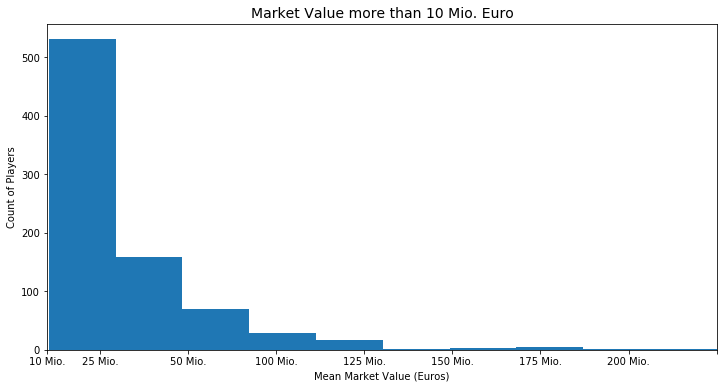

In [58]:
plt.figure(figsize=[12,6])
plt.hist(market_value_high/1000000, bins=10)
plt.title('Market Value more than 10 Mio. Euro', fontsize=14)
plt.ylabel('Count of Players')
plt.xlabel('Mean Market Value (Euros)')
plt.xlim(10, 200)
plt.xticks([10, 25, 50, 75, 100, 125, 150, 175, 200], ['10 Mio.', '25 Mio.', '50 Mio.', '100 Mio.', '125 Mio.', '150 Mio.','175 Mio.','200 Mio.']);

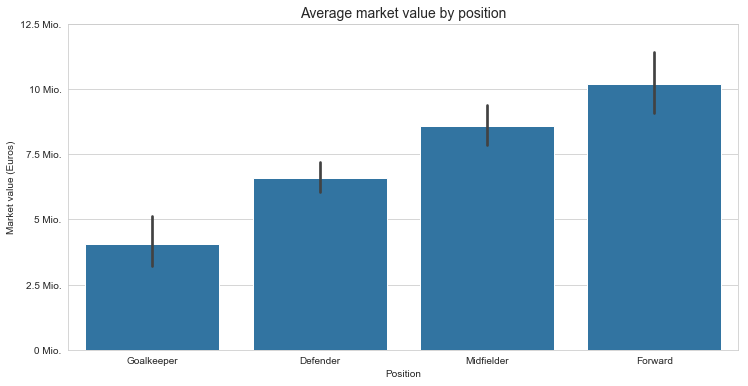

In [59]:
sb.set_style("whitegrid")
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.barplot(x="Position", y="Market Value (Euros)", data=df_clean, color=base_color) 
g.set(xlabel='Position', ylabel='Market value (Euros)')
g.set_title('Average market value by position', fontsize=14)
plt.yticks([0, 2500000 ,5000000, 7500000, 10000000, 12500000],['0 Mio.', '2.5 Mio.','5 Mio.', '7.5 Mio.','10 Mio.','12.5 Mio.']);

In [60]:
mean_marketvalue_by_league = df_clean.groupby(['League'])['Market Value (Euros)'].mean()/1000000

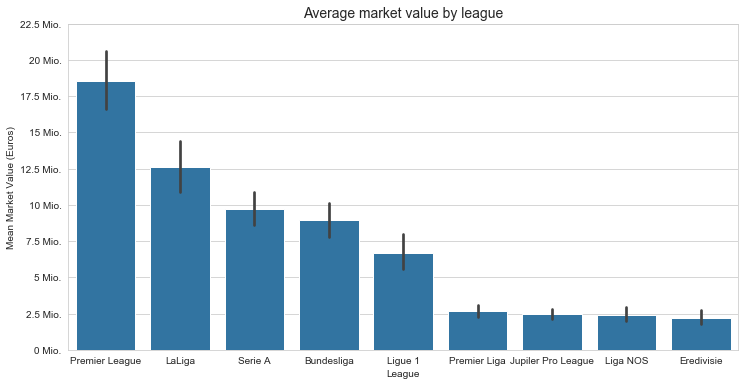

In [61]:
sb.set_style("whitegrid")
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.barplot(x="League", y="Market Value (Euros)", data=df_clean, color=base_color, order=mean_marketvalue_by_league.sort_values(ascending=False).index) 
g.set(xlabel='League', ylabel='Mean Market Value (Euros)')
g.set_title('Average market value by league', fontsize=14)
plt.yticks([0, 2500000 ,5000000, 7500000, 10000000, 12500000, 15000000, 17500000, 20000000, 22500000],['0 Mio.', '2.5 Mio.','5 Mio.', '7.5 Mio.','10 Mio.','12.5 Mio.','15 Mio.', '17.5 Mio.','20 Mio.', '22.5 Mio.']);

In [62]:
mean_marketvalue_by_club = df_clean.groupby(['Affiliation'])['Market Value (Euros)'].mean()/1000000

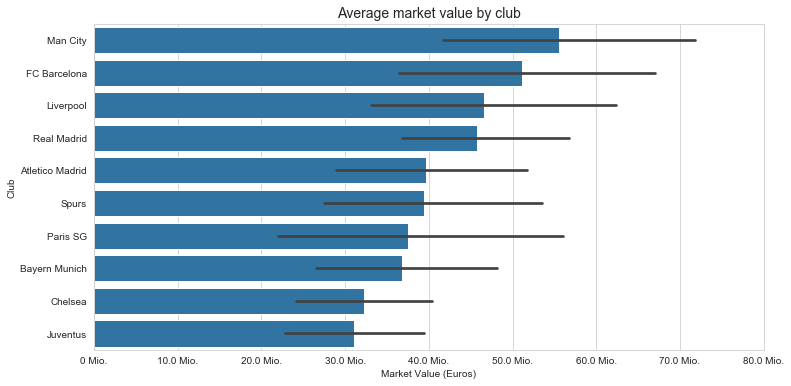

In [63]:
sb.set_style("whitegrid")
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.barplot(x="Market Value (Euros)", y="Affiliation", data=df_clean, color=base_color, order=mean_marketvalue_by_club.sort_values(ascending=False).iloc[:10].index)
g.set(xlabel='Market Value (Euros)', ylabel='Club')
g.set_title('Average market value by club', fontsize=14)
plt.xticks([0, 10000000 ,20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000],['0 Mio.', '10.0 Mio.','20.0 Mio.', '30.0 Mio.','40.0 Mio.','50.0 Mio.','60.0 Mio.','70.0 Mio.','80.0 Mio.']);

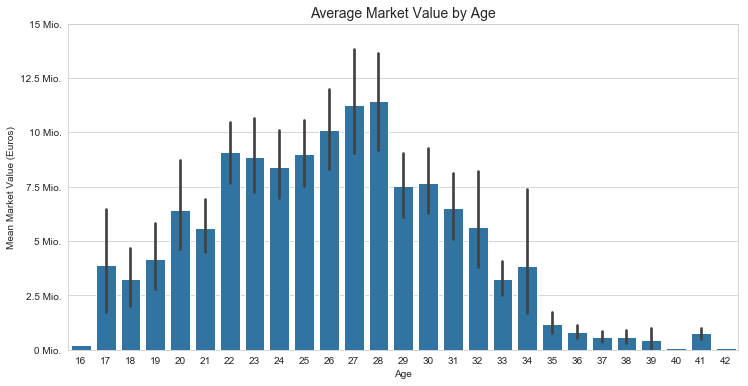

In [64]:
plt.figure(figsize=[12,6])
base_color = sb.color_palette()[0]
g = sb.barplot(x="Age", y="Market Value (Euros)", data=df_clean, color=base_color) 
g.set(xlabel='Age', ylabel='Mean Market Value (Euros)')
g.set_title('Average Market Value by Age', fontsize=14)
plt.yticks([0, 2500000 ,5000000, 7500000, 10000000, 12500000, 15000000],['0 Mio.', '2.5 Mio.','5 Mio.', '7.5 Mio.','10 Mio.','12.5 Mio.','15 Mio.']);

# 3 Machine Learning Model (KNN)

Predict the League of a player based on it's Position 2, Nationality, and Market Value (Euros) by using the k-nearest neighbor classifier.

In [65]:
#https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
nationality_encoded=le.fit_transform(df_clean['Nationality'])
position2_encoded=le.fit_transform(df_clean['Position 2'])

In [66]:
#https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
#using 'Position 2', 'Nationality' and 'Market Value (Euros)' to predict the 'League' of the player
X = list(zip(position2_encoded,nationality_encoded,df_clean['Market Value (Euros)']))
y = df_clean['League']

In [67]:
#https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

In [68]:
#https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
knn = KNeighborsClassifier(n_neighbors=15)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [69]:
#https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3983451536643026


## 4 Fazit
This model has an accuracy of around 40% so there's still a lot of room for improvement. However, this is my first supervised machine learning model I implemented, and I'm just familiarizing myself with it. Therefore I'm not too disappointed with my first result.